# Synthetic inversion of airborne EM data for imaging saltwater intrusion

## Purpose

Design a relvant constraint capturing the nature of saltwater intrusion. 
Use a 3D EM simulation code to generate synthetic AEM data, and invert them using the 1D code. 

## Action items

- Generate a synthetic model capturing a hydrogeologic set up of Monterey Coast, CA. 
- Run 3D EM simulation for a flight line, and generate synthetic AEM data. 
- Invert them using 1D inversion code with a minimial constraint. 
- Identify potential issues, and design a targeted form of inversion. 

## Step1: Generating a synthetic resistivity model

In [1]:
import numpy as np
from discretize import TensorMesh
import discretize.utils as disutils
from SimPEG import utils

dx = 100
dy = 100
dz = 5
hx = np.ones(101) * dx
hy = np.ones(101) * dx
hz = np.ones(60) * dz
mesh =TensorMesh([hx, hy, hz], x0=[-hx.sum()/2, -hy.sum()/2, -hz.sum() + 30.])
ind_active = mesh.gridCC[:,2]<0.
sigma_aquifer = 1./50.
sigma_aquitard = 1./15.

sigma_background = np.ones(mesh.n_cells) * 1./1e8
sigma_background[ind_active] = sigma_aquitard
layer_salinas_aquitard_ind = np.logical_and(mesh.gridCC[:,2]<0., mesh.gridCC[:,2]>-30)
layer_180_ft_aquifer = np.logical_and(mesh.gridCC[:,2]<-30., mesh.gridCC[:,2]>-80)
layer_180_400_ft_aquitard = np.logical_and(mesh.gridCC[:,2]<-80., mesh.gridCC[:,2]>-100)
layer_400_ft_aquifer = np.logical_and(mesh.gridCC[:,2]<-100., mesh.gridCC[:,2]>-160)
sigma_background[layer_180_ft_aquifer] = sigma_aquifer
sigma_background[layer_400_ft_aquifer] = sigma_aquifer
# time 1
sigma = sigma_background.copy()
salt_180_ft_aquifer = (layer_180_ft_aquifer) & (mesh.gridCC[:,0]<0.)
salt_400_ft_aquifer = (layer_400_ft_aquifer) & (mesh.gridCC[:,0]<-4000.)
sigma[salt_180_ft_aquifer] = 1./2.
sigma[salt_400_ft_aquifer] = 1./2.

p0 = np.r_[-1000, -500, -120]
p1 = np.r_[0, 500, -30]
inds_vert_salt = utils.model_builder.getIndicesBlock(p0, p1, mesh.gridCC)
sigma[inds_vert_salt] = 1./2.
rho = 1./sigma
rho[~ind_active] = np.nan

In [2]:
# time 2
sigma_later = sigma_background.copy()
salt_180_ft_aquifer = (layer_180_ft_aquifer) & (mesh.gridCC[:,0]<0. + 1000)
salt_400_ft_aquifer = (layer_400_ft_aquifer) & (mesh.gridCC[:,0]<-4000. + 1000)
sigma_later[salt_180_ft_aquifer] = 1./2.
sigma_later[salt_400_ft_aquifer] = 1./2.

p0 = np.r_[-1000, -500, -160]
p1 = np.r_[0, 500, -30]
inds_vert_salt = utils.model_builder.getIndicesBlock(p0, p1, mesh.gridCC)
sigma_later[inds_vert_salt] = 1./2.
rho_later = 1./sigma_later
rho_later[~ind_active] = np.nan

In [3]:
np.unique(sigma)

array([1.00000000e-08, 2.00000000e-02, 6.66666667e-02, 5.00000000e-01])

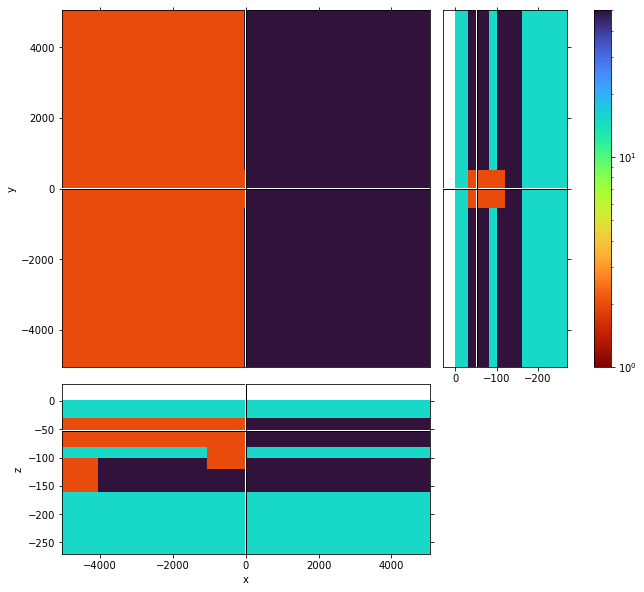

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(10, 10))
mesh.plot_3d_slicer(rho, pcolor_opts={'norm':LogNorm(vmin=1, vmax=50), 'cmap':'turbo_r'}, fig=fig, zslice=-50)

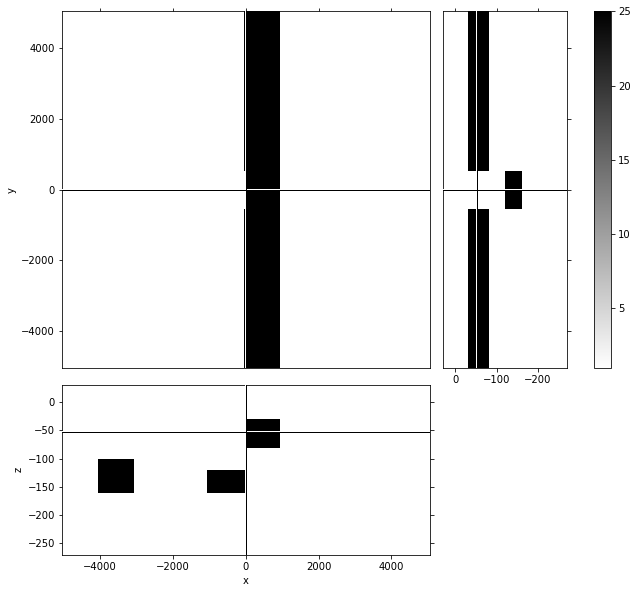

In [5]:
fig = plt.figure(figsize=(10, 10))
mesh.plot_3d_slicer(sigma_later/sigma, pcolor_opts={'cmap':'binary'}, fig=fig, zslice=-50)

## Step 2: Run 3D EM simulation 
### 2-1 Design a flight line

In [6]:
x = np.arange(91) * dx + -4500
y = np.r_[0.]
z = np.r_[0.]
topo = utils.ndgrid(x, y, z)
source_locations = np.c_[topo[:,:2], topo[:,2]+40.]
receiver_locations = np.c_[source_locations[:,0]+13.25, source_locations[:,1], source_locations[:,2]+2.] 

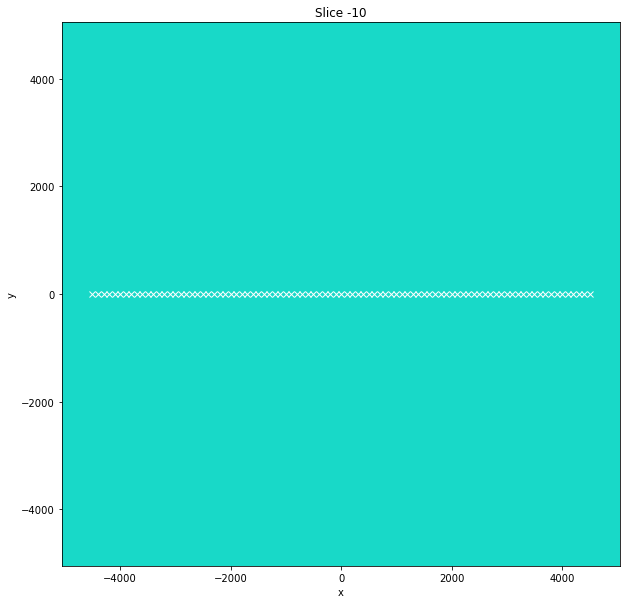

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
mesh.plot_slice(rho, pcolor_opts={'norm':LogNorm(vmin=1, vmax=50), 'cmap':'turbo_r'}, ax=ax, ind=-10)
ax.plot(source_locations[:,0], source_locations[:,1], 'wx')

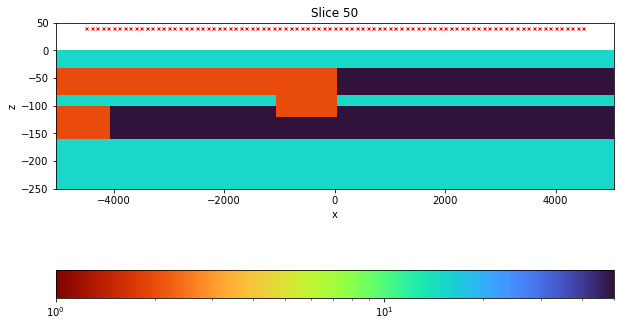

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
out = mesh.plot_slice(rho, pcolor_opts={'norm':LogNorm(vmin=1, vmax=50), 'cmap':'turbo_r'}, ax=ax, normal='Y')
ax.plot(source_locations[:,0], source_locations[:,2], 'rx', ms=3)
ax.set_ylim(-250, 50)
ax.set_aspect(10)
plt.colorbar(out[0], ax=ax, orientation='horizontal')

### 2-2 Genrerate a survey object

In [9]:
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps

>> Use cython version


In [10]:
receiver_orientation = "z"                    # "x", "y" or "z"
times = np.logspace(-5, -2, 41)               # time channels
source_radius = 10.
current_amplitude = 1.
source_list = []
n_src = topo.shape[0]

for i_src in range(n_src):
    source_location = source_locations[i_src,:]
    receiver_location = receiver_locations[i_src,:]

    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_location, times, orientation=receiver_orientation
        )
    ]

    # General Waveform
    source_list.append(
        tdem.sources.MagDipole(
            receiver_list=receiver_list, location=source_location,
            waveform=tdem.sources.StepOffWaveform(), orientation='z'
        ),
    )

# Survey
survey = tdem.Survey(source_list)

In [11]:
def generate_time_steps(
    n_constant_steps=15, increase_rate=3, start_time_step=5e-7, n_per_step=5
):
    time_steps = []
    for i_step in range(n_constant_steps):
        ht = np.ones(n_per_step) * start_time_step*increase_rate**i_step
        time_steps.append(ht)
    print("t_min:{:.1e}, t_max:{:.1e}".format(start_time_step, np.sum(time_steps)))
    return np.hstack(time_steps)

In [12]:
time_steps = generate_time_steps(n_constant_steps=13, increase_rate=2, start_time_step=5e-7, n_per_step=5)

t_min:5.0e-07, t_max:2.0e-02


In [16]:
from simpegaem import GlobalSimulationAEM
sim = GlobalSimulationAEM(
    mesh=mesh, 
    topo=topo, 
    sigmaMap=maps.IdentityMap(mesh), 
    survey=survey, 
    time_steps=time_steps, 
    parallel=True,
    n_cpu=4
)

>> Use multiprocessing for parallelization
>> n_cpu: 4


In [17]:
src = source_list[0]

In [ ]:
dpred = sim.dpred(sigma)

In [ ]:
dpred_later = sim.dpred(sigma_later)

In [ ]:
import dill

In [ ]:
output_dict={
    'data_1': dpred,
    'data_2': dpred_later,
    'source_locations': source_locations,
    'receiver_locations': receiver_locations,
    'topo': topo,
    'times': times,
    'waveform': 'stepoff', 
}

In [ ]:
dill.dump(output_dict, open('synthetic_aem_data.pik', 'wb'))

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

In [ ]:
_ =plt.semilogy(source_locations[:,0], -dpred.reshape(survey.nSrc, times.size)[:,:], 'k-', ms=1)
_ =plt.semilogy(source_locations[:,0], -dpred_later.reshape(survey.nSrc, times.size)[:,:], 'r--', ms=1)
# _ = plt.semilogy(source_locations[:,0], -dpred_later.reshape(survey.nSrc, times.size)[:,:3], 'r.', ms=1)

In [ ]:
ratio =  dpred_later/dpred

In [ ]:
for i_channel in range(0, times.size, 10):
    text = "{:.2f} ms".format(times[i_channel]*1e3)
    _ = plt.semilogy(source_locations[:,0], ratio.reshape(survey.nSrc, times.size)[:,i_channel], label=text)
plt.legend()

In [ ]:
_ = plt.loglog(times, -dpred.reshape(survey.nSrc, times.size).T, 'k', lw=1)
_ = plt.loglog(times, -dpred_later.reshape(survey.nSrc, times.size).T, 'r--', lw=1)

In [ ]:
_ = plt.loglog(times, ratio.reshape(survey.nSrc, times.size).T, 'k')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
out = plt.pcolormesh(
    source_locations[:,0], np.log10(times[:]*1e3), (ratio.reshape(survey.nSrc, times.size).T-1)[:,:]*100, 
    vmin=-100, vmax=100, cmap='RdBu_r'
)
cb = plt.colorbar(out)
ax.set_xlabel("Easting (m)")
yticks = ax.get_yticks()
ax.set_yticklabels(["{:.1e}".format(10**tick) for tick in yticks])
ax.set_ylabel("Time (ms)")
ax.invert_yaxis()
cb.set_label("Relative ratio")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
_ =plt.semilogy(source_locations[:,0], -dpred.reshape(survey.nSrc, times.size)[:,:], 'k-', ms=1)
_ =plt.semilogy(source_locations[:,0], -dpred_later.reshape(survey.nSrc, times.size)[:,:], 'r--', ms=1)
# _ = plt.semilogy(source_locations[:,0], -dpred_later.reshape(survey.nSrc, times.size)[:,:3], 'r.', ms=1)

In [ ]:
mesh.write_vtk('synthetic_3d_rho.vtr', models={'rho': rho, 'rho_later':rho_later})

In [ ]:
200 * 20 * 8 * 5